In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from pywsi.normalization import MacenkoNormalization
from pywsi.normalization import ReinhardNormalization

from pywsi.io import WSIReader
import numpy.linalg as LA

from sklearn.decomposition import NMF
from sklearn.decomposition import nmf
from sklearn.linear_model import Lasso

from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from numpy import linalg as LA
import spams


Populating the interactive namespace from numpy and matplotlib


In [2]:
tumor = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/normal/normal_038.tif'
normal = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_038.tif'

tumor_rgb = WSIReader(tumor, 40).get_patch_by_level(0, 0, level=5)
normal_rgb = WSIReader(normal, 40 ).get_patch_by_level(0, 0, level=5)

# Macenko normalization

In [3]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(tumor_rgb).astype(np.uint8))
normalized_rgb = macenko_fit.transform(np.asarray(normal_rgb).astype(np.uint8))

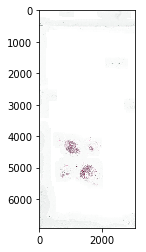

In [4]:
plt.imshow(normalized_rgb[0])


In [9]:
H_channel = macenko_fit.get_hematoxylin_channel(tumor_rgb)
E_channel = macenko_fit.get_eosin_channel(tumor_rgb)

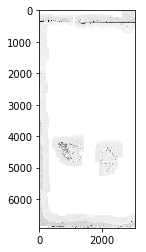

In [8]:
plt.imshow(H_channel, cmap='gray')

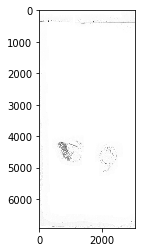

In [10]:
plt.imshow(E_channel, cmap='gray')

In [ ]:
dif = plt.figure(figsize=(10, 10))
ax = plt.subplot(131)
ax.set_axis_off()
ax.imshow(tumor_rgb)
ax.set_title('Tumor')

ax = plt.subplot(132)
ax.set_axis_off()
ax.imshow(normal_rgb)
ax.set_title('Normal')

ax = plt.subplot(133)
ax.set_axis_off()
ax.imshow(normalized_rgb[0])
ax.set_title('Normalized (Macenko)')




In [ ]:
def RGB2OD(image):
    """Convert Intensities to Optical Density"""
    assert np.issubdtype(image.dtype, np.uint8)
    image[np.where(image==0)] = 1
    return (-np.log(image/255.0))

def OD2RGB(OD):
    return 255 * np.exp(-OD)


class MacenkoNormalization(object):
    def __init__(self):
        """
        Input: RGB Slide
        1. Convert RGB to OD
        2. Remove data with OD intensity less than β
        3. Calculate SVD on the OD tuples
        4. Create plane from the SVD directions corresponding to the
        two largest singular values
        5. Project data onto the plane, and normalize to unit length
        6. Calculate angle of each point wrt the first SVD direction
        7. Find robust extremes (α th and (100 − α)th percentiles) of the
        angle
        8. Convert extreme values back to OD space

        """
        self.beta = 0.15
        self.alpha = 1
        self.OD = None
        
    def fit(self, target_image, beta=0.15):
        self.beta = beta
        self.target_stain_matrix = self.get_stain_matrix(target_image)
        self.target_concentrations = self.get_concentrations(target_image, self.target_stain_matrix)
        
    def get_stain_matrix(self, source_image):
        OD = RGB2OD(source_image)
        OD = OD.reshape((-1, 3))
        OD = (OD[(OD > self.beta).any(axis=1), :])
        ## do-PCA
        OD_cov = np.cov(OD, rowvar=False)
        w, v = LA.eigh(OD_cov)   
        # Project OD into first two directions
        # eigen values in ascending order
        v_first_two = v[:, [1, 2]]
        print(v.shape)
        projected = np.dot(OD, v_first_two)
        # find the min and max vectors and project back to OD space
        angle = np.arctan2(projected[:, 1], projected[:, 0])
        
        min_angle = np.percentile(angle, self.alpha)
        max_angle = np.percentile(angle, 100 - self.alpha)
        
        Vmin = np.dot(v_first_two, np.array([np.cos(min_angle), np.sin(min_angle)]))
        Vmax = np.dot(v_first_two, np.array([np.cos(max_angle), np.sin(max_angle)]))
        
        if Vmax[0] > Vmin[0]:
            HE = np.array([Vmax, Vmin])
        else:
            HE = np.array([Vmin, Vmax])
        HE = HE / np.linalg.norm(HE, axis=1)[:, None]        
        return HE
  
           
    
    def get_concentrations(self, image, stain_matrix):
        OD = RGB2OD(image).reshape((-1, 3))
        clf = Lasso(alpha=0.001, fit_intercept=False, max_iter=5000, tol=1e-2, copy_X=True)
        
        fit = clf.fit(OD.T, stain_matrix.T)
        coefs2 = spams.lasso(OD.T, D=stain_matrix.T, mode=2, lambda1=0.01, pos=True).toarray().T
        return coefs2
        return fit.coef_.T

    
    
    def transform(self, source_image):
        source_stain_matrix = self.get_stain_matrix(source_image)
        source_concentrations = self.get_concentrations(source_image, source_stain_matrix)
        
        maxC_source = np.percentile(source_concentrations, 99, axis=0).reshape((1, 2))
        maxC_target = np.percentile(self.target_concentrations, 99, axis=0).reshape((1, 2))
        print('maxC_source: {}'.format(maxC_source))
        print('maxC_target: {}'.format(maxC_target))
        source_concentrations *= (maxC_target / maxC_source)
        reconstructed = np.dot(source_concentrations, 
                               self.target_stain_matrix).reshape(source_image.shape)
        
        return OD2RGB(reconstructed).reshape(source_image.shape).astype(np.uint8)

In [ ]:
macenko_normalization = MacenkoNormalization()
macenko_fit = macenko_normalization.fit(np.asarray(tumor_rgb, dtype=np.uint8))
macenko_normalized = macenko_normalization.transform(np.asarray(normal_rgb, dtype=np.uint8))

In [ ]:
plt.imshow(macenko_normalized)